In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor

import time
import warnings

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [4]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

In [177]:
# Targeted Feature Engineering
Ames["GrLivArea_per_LotArea"] = Ames["GrLivArea"] / (Ames["LotArea"] + 1)
Ames["TotalSF"] = Ames["GrLivArea"] + Ames["TotalBsmtSF"]
Ames["HouseAge"] = Ames["YrSold"].astype(int) - Ames["YearBuilt"].astype(int)
Ames["HouseAgeSinceRemod"] = Ames["YrSold"].astype(int) - Ames["YearRemodAdd"].astype(int)
Ames["WasRemodeled"] = Ames['YearRemodAdd'] > Ames["YearBuilt"].astype(int)

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)
# initialize only if not already set
try:
    half_weight
except NameError:
    half_weight = 0.5

try:
    b_weight
except NameError:
    b_weight = 1.0

try:
    b_weight_half
except NameError:
    b_weight_half = 0.5


Ames['TotalBaths'] = Ames['FullBath'] + 0.5 * Ames['HalfBath'] + Ames['BsmtFullBath'] + 0.5 * Ames['BsmtHalfBath']

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# mapping dictionary
style_map = {
    "1Story": "Ranch",
    "SFoyer": "Ranch",
    "SLvl": "Ranch",
    "2Story": "Colonial",
    "2.5Fin": "Colonial",
    "2.5Unf": "Colonial",
    "1.5Fin": "Other",
    "1.5Unf": "Other"
}

# apply to dataset
Ames["RanchColonial"] = Ames["HouseStyle"].map(style_map)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['WasRemodeled'] = Ames['WasRemodeled'].astype('object')


# Add Interactions
Ames['GrLivArea_x_Qual'] = Ames['GrLivArea'] * Ames['OverallQual']
Ames['TotalSF_x_Qual'] = Ames['TotalSF'] * Ames['OverallQual']


X_fe = Ames.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [54]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: List[Tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,     # <— evaluator handles log target (since no TTR)
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    for name, est in models:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        for tr, va in kf.split(X):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(rmse(y_va, pred))
            oof[va] = pred

        # full-fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [15]:
warnings.filterwarnings("ignore")
cb_pipe = make_catboost_pipe(X_fe)

# Reasonable fast search space (40 trials)
param_dist = {
    "reg__n_estimators":      [700, 900, 1100, 1300, 1500],
    "reg__learning_rate":     np.logspace(np.log10(0.01), np.log10(0.2), 20),
    "reg__depth":             [4, 5, 6, 7, 8, 9],
    "reg__l2_leaf_reg":       np.logspace(-2, np.log10(50), 20),
    "reg__subsample":         [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg__colsample_bylevel": [0.6, 0.7, 0.8, 0.9, 1.0],
    # optional extra knobs if you want:
    # "reg__min_data_in_leaf":  [1, 5, 10, 20, 50],
    # "reg__grow_policy":       ["SymmetricTree", "Depthwise"],
}

cb_fast = RandomizedSearchCV(
    estimator=cb_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

cb_fast.fit(X_fe, y)
print("Fast best params:", cb_fast.best_params_)
print("Fast best CV RMSE:", -cb_fast.best_score_)
cb_fast_best = cb_fast.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fast best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1300, 'reg__learning_rate': np.float64(0.09091879706907821), 'reg__l2_leaf_reg': np.float64(3.39526919761953), 'reg__depth': 6, 'reg__colsample_bylevel': 0.8}
Fast best CV RMSE: 19428.268753125918


In [16]:
# from sklearn.model_selection import RandomizedSearchCV, KFold
# import numpy as np

cb_center = {
    "reg__n_estimators":      1300,
    "reg__learning_rate":     float(0.09091879706907821),
    "reg__depth":             6,
    "reg__l2_leaf_reg":       float(3.39526919761953),
    "reg__subsample":         0.8,
    "reg__colsample_bylevel": 0.8,
}

# jitter helpers
def jitter_around(v, pct=0.25, n=7, minv=None, maxv=None):
    vals = [v*(1 + t) for t in np.linspace(-pct, pct, n)]
    if minv is not None: vals = [max(minv, x) for x in vals]
    if maxv is not None: vals = [min(maxv, x) for x in vals]
    return sorted(set(vals))

param_dist_small = {
    "reg__learning_rate":     jitter_around(cb_center["reg__learning_rate"], pct=0.35, n=9, minv=0.01, maxv=0.2),
    "reg__l2_leaf_reg":       jitter_around(cb_center["reg__l2_leaf_reg"], pct=1.0,  n=9, minv=0.01, maxv=50),
    "reg__n_estimators":      [1100, 1200, 1300, 1400, 1500],
    # keep the structure that worked:
    "reg__depth":             [6],      # optionally try [5,6,7]
    "reg__subsample":         [0.8],    # optionally try [0.7, 0.8, 0.9]
    "reg__colsample_bylevel": [0.8],    # optionally try [0.7, 0.8, 0.9]
}

cb_micro = RandomizedSearchCV(
    estimator=make_catboost_pipe(X_fe),
    param_distributions=param_dist_small,
    n_iter=12,                               # fast! try 20 if you have time
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

cb_micro.fit(X_fe, y)
print("Micro best params:", cb_micro.best_params_)
print("Micro best CV RMSE:", -cb_micro.best_score_)
cb_best = cb_micro.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Micro best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1500, 'reg__learning_rate': np.float64(0.05909721809490084), 'reg__l2_leaf_reg': np.float64(6.79053839523906), 'reg__depth': 6, 'reg__colsample_bylevel': 0.8}
Micro best CV RMSE: 19372.53933924462


In [60]:
from sklearn.base import BaseEstimator, TransformerMixin

class BathWeighter(BaseEstimator, TransformerMixin):
    """
    Re-compute/overwrite TotalBaths using tunable weights.
    If 'TotalBaths' exists, it will be overwritten (prevents double counting).
    """
    def __init__(self, w_full=1.0, w_half=0.5, w_bfull=1.0, w_bhalf=0.5):
        self.w_full  = w_full
        self.w_half  = w_half
        self.w_bfull = w_bfull
        self.w_bhalf = w_bhalf

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        for col in ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]:
            if col not in X2.columns:
                # Silently proceed; if a column is missing, treat as zero.
                X2[col] = 0
        X2["TotalBaths"] = (
              self.w_full  * X2["FullBath"].fillna(0)
            + self.w_half  * X2["HalfBath"].fillna(0)
            + self.w_bfull * X2["BsmtFullBath"].fillna(0)
            + self.w_bhalf * X2["BsmtHalfBath"].fillna(0)
        )
        return X2

In [61]:
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    cbp = dict(cb_params)
    cbp.setdefault("loss_function", "RMSE")
    cbp.setdefault("random_state", 42)
    cbp.setdefault("verbose", 0)
    cbp.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cbp)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_catboost_pipe_with_baths(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    cbp = dict(cb_params)
    cbp.setdefault("loss_function", "RMSE")
    cbp.setdefault("random_state", 42)
    cbp.setdefault("verbose", 0)
    cbp.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cbp)
    return Pipeline([
        ("bath", BathWeighter()),   # <- computes/overwrites TotalBaths
        ("prep", pre),
        ("reg", reg),
    ])

In [62]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold

# center on what worked for you
cb_center = {
    "reg__n_estimators":      1500,
    "reg__learning_rate":     0.05909721809490084,
    "reg__depth":             6,
    "reg__l2_leaf_reg":       6.79053839523906,
    "reg__subsample":         0.8,
    "reg__rsm":               0.8,  # CatBoost param name for colsample at split-level
}

def jitter_around(v, pct=0.35, n=9, minv=None, maxv=None):
    vals = [v*(1 + t) for t in np.linspace(-pct, pct, n)]
    if minv is not None: vals = [max(minv, x) for x in vals]
    if maxv is not None: vals = [min(maxv, x) for x in vals]
    return sorted(set(vals))

param_dist_cb = {
    "reg__learning_rate": jitter_around(cb_center["reg__learning_rate"], pct=0.35, n=9, minv=0.01, maxv=0.2),
    "reg__l2_leaf_reg":   jitter_around(cb_center["reg__l2_leaf_reg"],   pct=0.75, n=9, minv=0.5,  maxv=30),
    "reg__n_estimators":  [1100, 1300, 1500, 1700],
    "reg__depth":         [5, 6, 7],      # you can freeze at [6] if you want
    "reg__subsample":     [0.7, 0.8, 0.9],
    "reg__rsm":           [0.7, 0.8, 0.9],
    # Optional stabilizers:
    "reg__random_strength":  [0, 0.5, 1.0],
    "reg__bagging_temperature": [0, 1],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=make_catboost_pipe(df_schema=X_fe),   # pass your schema-like df (columns/dtypes)
    param_distributions=param_dist_cb,
    n_iter=30,                                     # bump to 50–80 if you want more thoroughness
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,   # best pipeline refit on full data
)

# y should be your chosen target (raw price if that’s your best)
search.fit(X_fe, y_raw)

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)
best_pipe = search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'reg__subsample': 0.8, 'reg__rsm': 0.8, 'reg__random_strength': 1.0, 'reg__n_estimators': 1700, 'reg__learning_rate': np.float64(0.05909721809490084), 'reg__l2_leaf_reg': np.float64(5.517312446131736), 'reg__depth': 7, 'reg__bagging_temperature': 1}
Best CV RMSE: 19434.267059129197


In [63]:
param_dist_joint = {
    # CatBoost (narrower since you already have a good center)
    "reg__learning_rate": jitter_around(cb_center["reg__learning_rate"], pct=0.30, n=7, minv=0.02, maxv=0.12),
    "reg__l2_leaf_reg":   jitter_around(cb_center["reg__l2_leaf_reg"],   pct=0.75, n=7, minv=0.5,  maxv=20),
    "reg__n_estimators":  [1300, 1500, 1700],
    "reg__depth":         [6],    # keep fixed to reduce search noise
    "reg__subsample":     [0.8],
    "reg__rsm":           [0.8],

    # Bath weights
    "bath__w_half":  [0.4, 0.5, 0.6],
    "bath__w_bfull": [0.8, 1.0, 1.2],
    "bath__w_bhalf": [0.4, 0.5, 0.6],
}

search_joint = RandomizedSearchCV(
    estimator=make_catboost_pipe_with_baths(df_schema=X_fe),
    param_distributions=param_dist_joint,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

search_joint.fit(X_fe, y_raw)
print("Joint best params:", search_joint.best_params_)
print("Joint best CV RMSE:", -search_joint.best_score_)
best_joint_pipe = search_joint.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Joint best params: {'reg__subsample': 0.8, 'reg__rsm': 0.8, 'reg__n_estimators': 1300, 'reg__learning_rate': np.float64(0.0768263835233711), 'reg__l2_leaf_reg': np.float64(5.092903796429295), 'reg__depth': 6, 'bath__w_half': 0.5, 'bath__w_bhalf': 0.6, 'bath__w_bfull': 1.2}
Joint best CV RMSE: 19420.116349288943


In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.pipeline import Pipeline
import joblib

# --- your BathWeighter from earlier ---
class BathWeighter(BaseEstimator, TransformerMixin):
    def __init__(self, w_full=1.0, w_half=0.5, w_bfull=1.2, w_bhalf=0.6):
        self.w_full  = w_full
        self.w_half  = w_half
        self.w_bfull = w_bfull
        self.w_bhalf = w_bhalf
    def fit(self, X, y=None): return self
    def transform(self, X):
        X2 = X.copy()
        for col in ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]:
            if col not in X2.columns: X2[col] = 0
        X2["TotalBaths"] = (
              self.w_full  * X2["FullBath"].fillna(0)
            + self.w_half  * X2["HalfBath"].fillna(0)
            + self.w_bfull * X2["BsmtFullBath"].fillna(0)
            + self.w_bhalf * X2["BsmtHalfBath"].fillna(0)
        )
        return X2

# --- your preprocessor + pipeline constructor (as you shared) ---
def make_catboost_pipe_with_baths(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    p = dict(cb_params)
    p.setdefault("loss_function","RMSE")
    p.setdefault("random_state",42)
    p.setdefault("verbose",0)
    p.setdefault("thread_count",-1)
    reg = CatBoostRegressor(**p)
    return Pipeline([
        ("bath", BathWeighter(w_full=1.0, w_half=0.5, w_bfull=1.2, w_bhalf=0.6)),
        ("prep", pre),
        ("reg", reg),
    ])

# ==== 1) Recreate the joint-winner params (from your search) ====
best_params = dict(
    n_estimators   = 1300,
    learning_rate  = float(0.0768263835233711),
    l2_leaf_reg    = float(5.092903796429295),
    depth          = 6,
    subsample      = 0.8,
    rsm            = 0.8,
    random_strength= 0.0,   # not searched in the joint step; set if you want
    bagging_temperature=0,  # same note
    loss_function  = "RMSE",
    random_state   = 42,
    verbose        = 0,
    thread_count   = -1,
)

pipe = make_catboost_pipe_with_baths(df_schema=X_fe, **best_params)

# ==== 2) Polished refit with early stopping on a small holdout ====
X_tr, X_val, y_tr, y_val = train_test_split(X_fe, y_raw, test_size=0.1, random_state=42)

# Slightly bump trees to let ES work (e.g., +25–40%)
pipe.set_params(reg__n_estimators= int(best_params["n_estimators"] * 1.35))

# Fit; pass eval_set through CatBoost’s fit via pipeline’s final step
X_tr_prep = pipe.named_steps["prep"].fit_transform(
    pipe.named_steps["bath"].fit_transform(X_tr), y_tr
)
X_val_prep = pipe.named_steps["prep"].transform(
    pipe.named_steps["bath"].transform(X_val)
)

reg = pipe.named_steps["reg"]
reg.set_params(use_best_model=True)
reg.fit(
    X_tr_prep, y_tr,
    eval_set=Pool(X_val_prep, y_val),
    early_stopping_rounds=200,
    verbose=False
)

# put the trained regressor back
pipe.named_steps["reg"] = reg

# ==== 3) Save final pipeline ====
joblib.dump(pipe, "catboost_price_pipeline.pkl")
print("Saved to catboost_price_pipeline.pkl")

# ==== 4) Quick eval on the holdout ====
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pred_val = pipe.predict(X_val)

# plain MSE, then sqrt for RMSE
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae  = mean_absolute_error(y_val, pred_val)
r2   = r2_score(y_val, pred_val)

print(f"Holdout -> RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R2: {r2:.3f}")

# ==== 5) (Optional) Feature importance snapshot ====
# Use the *preprocessed* matrix columns for proper names:
feature_names = pipe.named_steps["prep"].get_feature_names_out()
fi = reg.get_feature_importance(type="FeatureImportance")
fi_df = pd.DataFrame({"feature": feature_names, "gain_importance": fi}) \
        .sort_values("gain_importance", ascending=False)
print(fi_df.head(25).to_string(index=False))

Saved to catboost_price_pipeline.pkl
Holdout -> RMSE: 20,754 | MAE: 13,002 | R2: 0.929
           feature  gain_importance
    TotalSF_x_Qual        41.588530
  GrLivArea_x_Qual         9.617874
        TotalBaths         4.000173
HouseAgeSinceRemod         3.329577
           LotArea         3.300274
        BsmtFinSF1         2.654220
          HouseAge         2.296627
        Fireplaces         1.912328
       KitchenQual         1.877695
         YearBuilt         1.710527
        GarageArea         1.708099
       OverallCond         1.700977
      BsmtExposure         1.476273
 GarageType_Attchd         1.400279
           TotalSF         1.296381
      YearRemodAdd         1.000361
          1stFlrSF         0.957797
         BsmtUnfSF         0.852131
        MasVnrArea         0.814700
       GarageYrBlt         0.779559
          BsmtQual         0.678352
        WoodDeckSF         0.634993
      BsmtFinType1         0.626559
       OpenPorchSF         0.599785
       MSZoni

In [68]:
def ensure_totalbaths_with_weights(
    X: pd.DataFrame,
    w_full=1.0, w_half=0.5, w_bfull=1.2, w_bhalf=0.6,
    colname="TotalBaths", drop_existing=True
) -> pd.DataFrame:
    X2 = X.copy()
    # optionally remove any existing TotalBaths so we don't carry the old 0.5/0.5 version
    if drop_existing and colname in X2.columns:
        X2 = X2.drop(columns=[colname])
    # compute with your tuned weights (keeps base components too)
    if all(c in X2.columns for c in ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]):
        X2[colname] = (
            w_full  * X2["FullBath"].fillna(0)
          + w_half  * X2["HalfBath"].fillna(0)
          + w_bfull * X2["BsmtFullBath"].fillna(0)
          + w_bhalf * X2["BsmtHalfBath"].fillna(0)
        )
    return X2

In [70]:
X_adj = ensure_totalbaths_with_weights(X_fe, 1.0, 0.5, 1.2, 0.6)

In [94]:
df_eval = X_fe.copy()
df_eval["y_true"] = y_raw
df_eval["y_pred"] = cb_best.predict(X_fe)
df_eval["residual"] = df_eval["y_true"] - df_eval["y_pred"]

In [95]:
cutoff = np.percentile(df_eval["residual"], 80)  # top 20% most underpriced
df_eval["underpriced_flag"] = (df_eval["residual"] >= cutoff).astype(int)

In [96]:
def simulate_upgrade(row):
    upgraded = row.copy()

    # kitchen
    kitchen_levels = ["Po","Fa","TA","Gd","Ex"]
    if row["KitchenQual"] in kitchen_levels[:-1]:
        upgraded["KitchenQual"] = kitchen_levels[kitchen_levels.index(row["KitchenQual"]) + 1]

    # add half bath -> full bath equivalent
    upgraded["TotalBaths"] = row["TotalBaths"] + 1  

    # optional: porch, deck
    upgraded["WoodDeckSF"] = row["WoodDeckSF"] + 100  

    return upgraded

In [97]:
upgraded_preds = []
for idx, row in df_eval[df_eval["underpriced_flag"] == 1].iterrows():
    upgraded_row = simulate_upgrade(row)
    upgraded_price = cb_best.predict(pd.DataFrame([upgraded_row]))[0]
    upgraded_preds.append((idx, upgraded_price))

In [106]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional

# ----------------------------
# 0) Ordinal ladders for “+1 step” and “best”
# ----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
}

# ----------------------------
# 1) Upgrade catalog (your list)
# ----------------------------
UPGRADES = [
    # Quality to best / +1 step (categoricals)
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},

    # Numeric deltas
    {"feature": "GarageCars",   "delta": +1.0,   "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",   "delta": +1.0,   "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",      "delta": +200.,  "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",   "delta": +100.,  "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",   "delta": +100.,  "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF",  "delta": +50.,   "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch",  "delta": +50.,   "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50.,   "upgrade": "EnclosedPorch +50.0"},
]

# ----------------------------
# 2) Helper: ensure/overwrite TotalBaths (optional)
# ----------------------------
def ensure_totalbaths(
    df: pd.DataFrame,
    overwrite: bool = True,
    w_full: float = 1.0,
    w_half: float = 0.5,
    w_bfull: float = 1.2,
    w_bhalf: float = 0.6,
) -> pd.DataFrame:
    df2 = df.copy()
    needed = {"FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"}
    if overwrite or ("TotalBaths" not in df2.columns and needed.issubset(df2.columns)):
        # fillna to 0 for bath counts to avoid NaNs
        for c in needed:
            if c in df2.columns:
                df2[c] = df2[c].fillna(0)
        df2["TotalBaths"] = (
            w_full  * df2.get("FullBath", 0)
          + w_half  * df2.get("HalfBath", 0)
          + w_bfull * df2.get("BsmtFullBath", 0)
          + w_bhalf * df2.get("BsmtHalfBath", 0)
        )
    return df2

# ----------------------------
# 3) Helper: apply a single upgrade to a row (Series)
# ----------------------------
def _bump_categorical(val: str, feature: str, step: int, ladders: Dict[str, List[str]]) -> str:
    ladder = ladders.get(feature)
    s = str(val) if pd.notna(val) else "None"
    if not ladder:
        return s  # no known ordering
    if s not in ladder:
        # try to coerce unknowns to nearest (treat as lowest)
        s = ladder[0]
    idx = ladder.index(s)
    new_idx = max(0, min(len(ladder)-1, idx + step))
    return ladder[new_idx]

def _to_best_categorical(val: str, feature: str, ladders: Dict[str, List[str]]) -> str:
    ladder = ladders.get(feature)
    if not ladder:
        return str(val) if pd.notna(val) else "None"
    return ladder[-1]  # best = max

def apply_upgrade_to_row(
    row: pd.Series,
    upgrade: Dict,
    ladders: Dict[str, List[str]],
    numeric_floor: float = 0.0
) -> pd.Series:
    r = row.copy()
    feat = upgrade["feature"]

    if feat not in r.index:
        return r  # silently skip missing features

    # categorical actions
    if "to" in upgrade and upgrade["to"] == "best":
        r[feat] = _to_best_categorical(r[feat], feat, ladders)
        return r

    if "step" in upgrade:
        # +1 step on ordinal cat
        r[feat] = _bump_categorical(r[feat], feat, int(upgrade["step"]), ladders)
        return r

    # numeric deltas
    if "delta" in upgrade:
        base = r[feat]
        try:
            new_val = float(base) + float(upgrade["delta"])
        except Exception:
            # if it’s a non-numeric feature, skip safely
            return r
        if numeric_floor is not None:
            new_val = max(numeric_floor, new_val)
        r[feat] = new_val
        return r

    return r

# ----------------------------
# 4) Main: find uplift candidates
# ----------------------------
def find_uplift_candidates(
    cb_pipe,                # trained Pipeline(prep -> CatBoostRegressor)
    X: pd.DataFrame,
    y: pd.Series,
    upgrades: List[Dict] = UPGRADES,
    ladders: Dict[str, List[str]] = ORDINAL_ORDER,
    underpriced_top_pct: float = 0.30,     # residual filter (top 30% underpriced)
    overwrite_totalbaths: bool = False,    # overwrite TotalBaths (set True to use your tuned weights)
    bath_weights: Tuple[float,float,float,float] = (1.0, 0.5, 1.2, 0.6),  # (full, half, bfull, bhalf)
    id_col: Optional[str] = "__row_id__",  # used for traceability if present
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      - candidates_summary: one row per property (underpriced subset) with best uplift + best upgrade
      - upgrades_long: long table of every (property, upgrade) uplift
    """
    # optional TotalBaths overwrite
    Xw = ensure_totalbaths(
        X, overwrite=overwrite_totalbaths,
        w_full=bath_weights[0], w_half=bath_weights[1],
        w_bfull=bath_weights[2], w_bhalf=bath_weights[3]
    )

    # base predictions + residuals
    base_pred = cb_pipe.predict(Xw)
    df_eval = Xw.copy()
    df_eval["y_true"] = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else np.asarray(y)
    df_eval["y_pred"] = base_pred
    df_eval["residual"] = df_eval["y_true"] - df_eval["y_pred"]  # >0 => underpredicted => underpriced

    # choose underpriced top pct
    cutoff = np.percentile(df_eval["residual"], 100*(1-underpriced_top_pct))
    mask = df_eval["residual"] >= cutoff
    underpriced = df_eval[mask].copy()

    # track id/index
    if id_col in Xw.columns:
        underpriced["_id_"] = underpriced[id_col].values
    else:
        underpriced["_id_"] = underpriced.index.astype(str)

    # simulate upgrades (one-by-one, not cumulative)
    rows = []
    for idx, row in underpriced.iterrows():
        base_price = float(row["y_pred"])
        for up in upgrades:
            urow = apply_upgrade_to_row(row, up, ladders)
            # keep same index/columns shape for pipeline prediction
            # IMPORTANT: only pass model feature columns (avoid extra columns we added like y_true, etc.)
            cols_for_model = Xw.columns  # pipeline was trained on these
            uX = pd.DataFrame([urow[cols_for_model].values], columns=cols_for_model, index=[idx])
            new_pred = float(cb_pipe.predict(uX)[0])
            uplift = new_pred - base_price
            rows.append({
                "_id_": underpriced.loc[idx, "_id_"],
                "_idx": idx,
                "upgrade": up.get("upgrade", f"{up.get('feature')} change"),
                "feature": up.get("feature"),
                "base_pred": base_price,
                "new_pred": new_pred,
                "uplift": uplift,
                "residual": float(row["residual"]),
                "y_true": float(row["y_true"]),
            })
    upgrades_long = pd.DataFrame(rows)

    if len(upgrades_long) == 0:
        # no underpriced homes; return empty
        return pd.DataFrame(), pd.DataFrame()

    # ===== DROP-IN: replace your existing "best_per_home = ..." through the merge to per_home =====
    
    # 0) Make sure upgrades_long has scalar join keys with consistent dtypes
    #    (_idx as int, _id_ as string). If _id_ wasn't carried into upgrades_long earlier,
    #    create it from X (preferring id_col if present).
    if "_id_" not in upgrades_long.columns:
        if (id_col is not None) and (id_col in X.columns):
            upgrades_long["_id_"] = X[id_col].astype(str).values
        else:
            upgrades_long["_id_"] = X.reset_index().index.astype(str).values
    
    upgrades_long["_idx"] = upgrades_long["_idx"].astype(int)
    upgrades_long["_id_"] = upgrades_long["_id_"].astype(str)
    
    # 1) Keep only underpriced rows
    under_idx = set(underpriced.index.to_numpy())
    upd_under = upgrades_long.loc[upgrades_long["_idx"].isin(under_idx)].copy()
    
    # 2) Pick the single best upgrade per home (max uplift) using sort -> groupby.first
    upd_under.sort_values(["_idx", "uplift"], ascending=[True, False], inplace=True)
    
    best_per_home = (
        upd_under
          .groupby("_idx", as_index=False)
          .first()[["_idx", "_id_", "base_pred", "new_pred", "uplift", "feature", "upgrade"]]
          .rename(columns={
              "new_pred":    "best_new_pred",
              "uplift":      "best_uplift",
              "feature":     "best_feature",
              "upgrade":     "best_upgrade",
          })
    )
    
    # Ensure clean scalar dtypes on text cols (just in case)
    best_per_home["_id_"]         = best_per_home["_id_"].astype(str)
    best_per_home["best_feature"] = best_per_home["best_feature"].astype(str)
    best_per_home["best_upgrade"] = best_per_home["best_upgrade"].astype(str)
    
    # 3) Build the left side (underpriced homes) with matching key dtypes
    per_home = (
        underpriced.reset_index()[["index", "_id_", "y_true", "residual"]]
                  .rename(columns={"index": "_idx"})
    )
    per_home["_idx"] = per_home["_idx"].astype(int)
    per_home["_id_"] = per_home["_id_"].astype(str)
    
    # 4) Merge + final ordering
    per_home = (
        per_home.merge(best_per_home, on=["_idx", "_id_"], how="left")
                .sort_values(["residual", "best_uplift"], ascending=[False, False], ignore_index=True)
    )
    
    # 5) Optional: keep a neat set/order of columns if they exist
    desired_cols = [
        "_id_", "_idx", "y_true", "residual",
        "base_pred", "best_uplift", "best_new_pred",
        "best_feature", "best_upgrade"
    ]
    per_home = per_home.reindex(columns=[c for c in desired_cols if c in per_home.columns])
    # ===== END DROP-IN =====

    # If you want to attach some original columns for viewing (optional):
    # e.g., add a few interpretable columns:
    show_cols = [c for c in ["Neighborhood","MSZoning","KitchenQual","OverallQual","GrLivArea","TotalBaths","GarageArea","TotalSF","YearBuilt","YearRemodAdd"] if c in Xw.columns]
    if show_cols:
        per_home = per_home.merge(
            Xw[show_cols].reset_index().rename(columns={"index":"_idx"}),
            on="_idx", how="left"
        )

    # sort by uplift or by a blend (residual + uplift)
    # here we keep it simple: primary = best_uplift, tie-breaker = residual
    per_home = per_home.sort_values(["best_uplift","residual"], ascending=[False, False]).reset_index(drop=True)

    return per_home, upgrades_long

In [107]:
# if you just created cb_pipe = make_catboost_pipe(...), you still need to fit it:
cb_pipe = cb_pipe.fit(X_adj, y_raw)   # <- fit on the full set (or your CV/train split)

In [108]:
# 1) Ensure you have a fitted pipeline (prep -> CatBoostRegressor)
   # e.g., cb_pipe = make_catboost_pipe(X_fe, **best_params).fit(X_fe, y_raw)

# 2) Run the finder
candidates_summary, upgrades_long = find_uplift_candidates(
    cb_pipe=cb_pipe,
    X=X_adj,                # or X_adj if you prefer that schema
    y=y_raw,
    upgrades=UPGRADES,     # your list
    underpriced_top_pct=0.30,   # top 30% most underpriced by residuals
    overwrite_totalbaths=False, # keep existing TotalBaths
    bath_weights=(1.0, 0.5, 1.2, 0.6),  # ignored unless overwrite_totalbaths=True
    id_col="__row_id__",   # if present
)

print("Top candidates (by uplift among underpriced):")
print(candidates_summary.head(20))

print("\nExample upgrade impacts (long table):")
print(upgrades_long.head(20))

Top candidates (by uplift among underpriced):
   _id_  _idx  y_true     residual      base_pred   best_uplift  \
0   113   113  555000  9738.512811  545261.487189  16857.926482   
1   113   113  555000  9738.512811  545261.487189  16857.926482   
2   113   113  555000  9738.512811  545261.487189  16857.926482   
3   579   579  425000  7225.176589  417774.823411  14659.945621   
4   579   579  425000  7225.176589  417774.823411  14659.945621   
5   579   579  425000  7225.176589  417774.823411  14659.945621   
6   620   620  256000  5261.315845  250738.684155  14296.729380   
7   620   620  256000  5261.315845  250738.684155  14296.729380   
8   620   620  256000  5261.315845  250738.684155  14296.729380   
9   818   818  404000  9146.774208  394853.225792  14115.298191   
10  333   333  378500  4244.354745  374255.645255  12795.483316   
11  333   333  378500  4244.354745  374255.645255  12795.483316   
12  333   333  378500  4244.354745  374255.645255  12795.483316   
13  228   228   

In [109]:
print("Top candidates (by uplift among underpriced):")
display(candidates_summary.head(20))

print("\nExample upgrade impacts (long table):")
display(upgrades_long.head(20))

Top candidates (by uplift among underpriced):


,_id_,_idx,y_true,residual,base_pred,best_uplift,best_new_pred,best_feature,best_upgrade,Neighborhood,MSZoning,KitchenQual,OverallQual,GrLivArea,TotalBaths,GarageArea,TotalSF,YearBuilt,YearRemodAdd
0,113,113,555000,9738.512811,545261.487189,16857.926482,562119.413671,TotalBaths,TotalBaths +1.0,NWAmes,RL,TA,7,2044,2.5,489.0,2782.0,1980,1988
1,113,113,555000,9738.512811,545261.487189,16857.926482,562119.413671,TotalBaths,TotalBaths +1.0,NridgHt,RL,Ex,10,2402,3.2,672.0,5496.0,2008,2008
2,113,113,555000,9738.512811,545261.487189,16857.926482,562119.413671,TotalBaths,TotalBaths +1.0,CollgCr,RL,Gd,7,1232,3.2,632.0,2464.0,2007,2007
3,579,579,425000,7225.176589,417774.823411,14659.945621,432434.769032,TotalBaths,TotalBaths +1.0,Timber,RL,Ex,9,1978,3.2,920.0,3956.0,2007,2007
4,579,579,425000,7225.176589,417774.823411,14659.945621,432434.769032,TotalBaths,TotalBaths +1.0,IDOTRR,C (all),TA,4,1336,1.5,570.0,1973.0,1920,1950
5,579,579,425000,7225.176589,417774.823411,14659.945621,432434.769032,TotalBaths,TotalBaths +1.0,NAmes,RL,TA,7,1986,2.5,486.0,2754.0,1965,1990
6,620,620,256000,5261.315845,250738.684155,14296.729380,265035.413535,KitchenQual,KitchenQual → best (max),Sawyer,RL,TA,6,1921,2.0,576.0,3842.0,1964,1964
7,620,620,256000,5261.315845,250738.684155,14296.729380,265035.413535,KitchenQual,KitchenQual → best (max),NAmes,RL,TA,4,1040,2.0,420.0,1040.0,1949,1950
8,620,620,256000,5261.315845,250738.684155,14296.729380,265035.413535,KitchenQual,KitchenQual → best (max),OldTown,RM,TA,6,2792,2.0,520.0,4302.0,1920,1950
9,818,818,404000,9146.774208,394853.225792,14115.298191,408968.523983,TotalBaths,TotalBaths +1.0,NridgHt,RL,Ex,9,2020,3.2,896.0,4040.0,2008,2008



Example upgrade impacts (long table):


,_id_,_idx,upgrade,feature,base_pred,new_pred,uplift,residual,y_true
0,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,ExterQual → best (max),ExterQual,120800.049666,127429.000652,6628.950986,5199.950334,126000.0
1,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,KitchenQual → best (max),KitchenQual,120800.049666,125368.388115,4568.338450,5199.950334,126000.0
2,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,ExterQual +1 step,ExterQual,120800.049666,121880.147988,1080.098322,5199.950334,126000.0
3,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,KitchenQual +1 step,KitchenQual,120800.049666,122918.697685,2118.648019,5199.950334,126000.0
4,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,GarageCars +1.0,GarageCars,120800.049666,122292.026960,1491.977294,5199.950334,126000.0
5,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,TotalBaths +1.0,TotalBaths,120800.049666,122366.858870,1566.809204,5199.950334,126000.0
6,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,TotalSF +200.0,TotalSF,120800.049666,122239.618846,1439.569180,5199.950334,126000.0
7,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,WoodDeckSF +100.0,WoodDeckSF,120800.049666,121212.318607,412.268941,5199.950334,126000.0
8,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,GarageArea +100.0,GarageArea,120800.049666,120925.032801,124.983135,5199.950334,126000.0
9,"1 1\n1 1\n1 1\nName: _id_, dtype: object",1,OpenPorchSF +50.0,OpenPorchSF,120800.049666,120854.325883,54.276218,5199.950334,126000.0


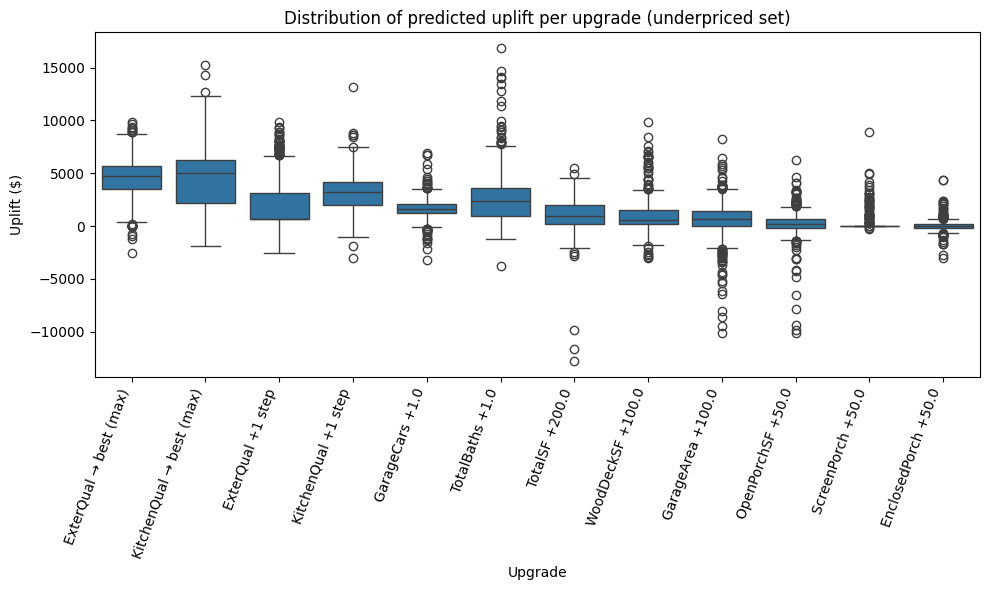

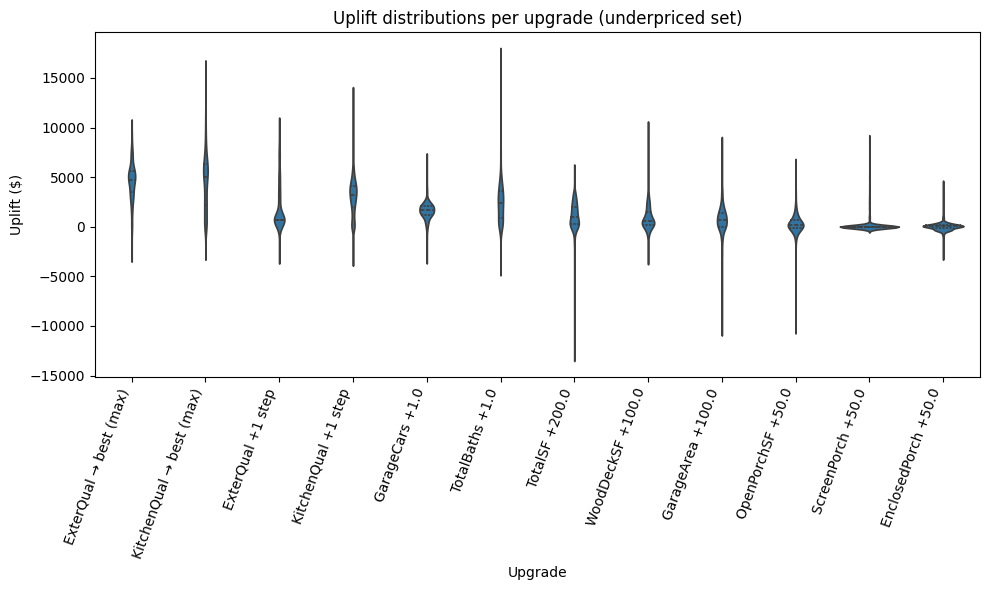

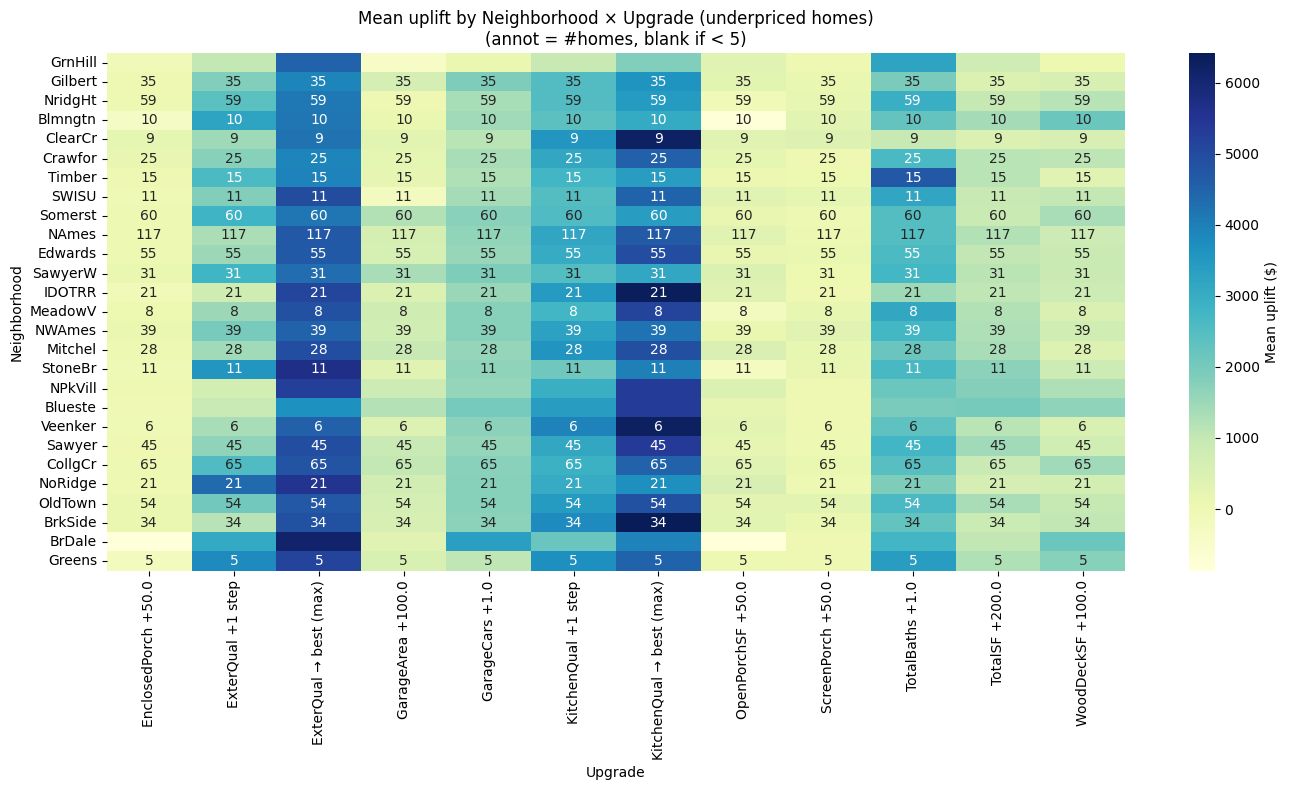

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Use the same table you used to produce upgrades_long/candidates_summary
X_ctx = X_adj   # or X_adj

# Which context columns to attach
CTX_COLS = ["Neighborhood"]   # add more if desired (e.g., "MSZoning")

def attach_context_with_dupe_safe_index(upgrades_long: pd.DataFrame,
                                        X: pd.DataFrame,
                                        ctx_cols):
    """
    Map context columns from X to upgrades_long via '_idx',
    handling non-unique X.index safely by keeping the *first* occurrence.
    """
    if "_idx" not in upgrades_long.columns:
        raise ValueError("upgrades_long must contain '_idx' to merge context.")

    # Build a lookup table from X's index values -> context columns,
    # deduped on the index label (keep first occurrence).
    X_map = (
        X.reset_index()
         .rename(columns={"index": "_idx"})         # turn index into a column named '_idx'
         .drop_duplicates(subset="_idx", keep="first")
         .set_index("_idx")
    )

    # Align to upgrades_long order
    ctx = X_map.reindex(upgrades_long["_idx"]).loc[:, ctx_cols]

    out = upgrades_long.copy()
    for c in ctx_cols:
        out[c] = ctx[c].to_numpy()
    return out

# 1) Enrich upgrades_long
upgrades_long_ctx = attach_context_with_dupe_safe_index(upgrades_long, X_ctx, CTX_COLS)

# 2) Per-upgrade uplift distributions (box + violin)
plt.figure(figsize=(10, 6))
sns.boxplot(data=upgrades_long_ctx, x="upgrade", y="uplift")
plt.xticks(rotation=70, ha="right")
plt.title("Distribution of predicted uplift per upgrade (underpriced set)")
plt.ylabel("Uplift ($)")
plt.xlabel("Upgrade")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=upgrades_long_ctx, x="upgrade", y="uplift", inner="quart")
plt.xticks(rotation=70, ha="right")
plt.title("Uplift distributions per upgrade (underpriced set)")
plt.ylabel("Uplift ($)")
plt.xlabel("Upgrade")
plt.tight_layout()
plt.show()

# 3) Neighborhood × Upgrade heatmap (mean uplift), with count annotations
heat = (
    upgrades_long_ctx
    .groupby(["Neighborhood", "upgrade"], dropna=False)["uplift"]
    .mean()
    .unstack("upgrade")
)

counts = (
    upgrades_long_ctx
    .groupby(["Neighborhood", "upgrade"], dropna=False)["uplift"]
    .size()
    .unstack("upgrade")
    .fillna(0)
    .astype(int)
)

heat = heat.reindex(heat.mean(axis=1).sort_values().index)
counts = counts.reindex(heat.index)

MIN_N = 5  # hide annotations if fewer than MIN_N samples
annot_mat = counts.where(counts >= MIN_N)
annot_str = annot_mat.applymap(lambda v: "" if pd.isna(v) else f"{int(v)}")

plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    heat,
    cmap="YlGnBu",
    annot=annot_str,   # show counts (blank if < MIN_N)
    fmt="",
    cbar_kws={"label": "Mean uplift ($)"}
)
plt.title(f"Mean uplift by Neighborhood × Upgrade (underpriced homes)\n(annot = #homes, blank if < {MIN_N})")
plt.ylabel("Neighborhood")
plt.xlabel("Upgrade")
plt.tight_layout()
plt.show()

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- core pivots once ----------
def _prep_uplift_pivots(upgrades_long_ctx, upgrade_order, min_n=5, pct_clip=0.10):
    df = upgrades_long_ctx.copy()

    # % uplift (relative to base_pred), clipped for readability
    df["pct_uplift"] = df["uplift"] / np.where(df["base_pred"].abs() < 1e-9, np.nan, df["base_pred"])
    df["pct_uplift_clip"] = df["pct_uplift"].clip(-pct_clip, pct_clip)

    # mean($), mean(%), and counts per Neighborhood×Upgrade
    agg_dollar = (df.groupby(["Neighborhood","upgrade"], as_index=False)["uplift"]
                    .mean().rename(columns={"uplift":"mean_uplift_dollar"}))
    agg_pct = (df.groupby(["Neighborhood","upgrade"], as_index=False)["pct_uplift_clip"]
                 .mean().rename(columns={"pct_uplift_clip":"mean_uplift_pct"}))
    counts = (df.groupby(["Neighborhood","upgrade"], as_index=False)["_idx"]
                .count().rename(columns={"_idx":"n"}))

    agg = agg_dollar.merge(agg_pct, on=["Neighborhood","upgrade"], how="outer") \
                    .merge(counts, on=["Neighborhood","upgrade"], how="outer")

    # wide pivots
    piv_dollar = agg.pivot(index="Neighborhood", columns="upgrade", values="mean_uplift_dollar")
    piv_pct    = agg.pivot(index="Neighborhood", columns="upgrade", values="mean_uplift_pct")
    piv_n      = agg.pivot(index="Neighborhood", columns="upgrade", values="n")

    # consistent column order
    cols = [c for c in upgrade_order if c in piv_dollar.columns]
    piv_dollar = piv_dollar.reindex(columns=cols)
    piv_pct    = piv_pct.reindex(columns=cols)
    piv_n      = piv_n.reindex(columns=cols)

    # neighborhood-level counts (max across upgrades)
    n_row = piv_n.max(axis=1, skipna=True).fillna(0).astype(int)

    # mask for low sample size
    mask = (piv_n < min_n)

    # row-normalized versions (neighborhood-relative)
    def row_minmax_norm(mat):
        out = mat.copy()
        v = out.values
        rmin = np.nanmin(v, axis=1, keepdims=True)
        rmax = np.nanmax(v, axis=1, keepdims=True)
        denom = np.where((rmax - rmin) > 0, (rmax - rmin), np.nan)
        out[:] = (v - rmin) / denom
        return out

    rel_dollar = row_minmax_norm(piv_dollar)
    rel_pct    = row_minmax_norm(piv_pct)

    return piv_dollar, piv_pct, rel_dollar, rel_pct, mask, n_row

# ---------- one-plot helper ----------
def plot_uplift_heatmap_single(
    upgrades_long_ctx,
    upgrade_order,
    kind="global_dollar",      # "global_dollar", "global_percent", "rel_dollar", "rel_percent"
    min_n=5,
    pct_clip=0.10,
    figsize=(12, 7),
    cmap=None,
    vmin=None, vmax=None,
    title=None,
):
    piv_dollar, piv_pct, rel_dollar, rel_pct, mask, n_row = _prep_uplift_pivots(
        upgrades_long_ctx, upgrade_order, min_n=min_n, pct_clip=pct_clip
    )

    # choose matrix + defaults
    if kind == "global_dollar":
        data = piv_dollar
        default_cmap = "YlGnBu"
        cbar_label = "Mean uplift ($)"
    elif kind == "global_percent":
        data = piv_pct
        default_cmap = "PuBuGn"
        cbar_label = f"Mean uplift (% of base) [clip ±{int(100*pct_clip)}%]"
    elif kind == "rel_dollar":
        data = rel_dollar
        default_cmap = "YlGnBu"
        cbar_label = "Row-normalized uplift ($, 0..1)"
        vmin, vmax = (0, 1) if (vmin is None and vmax is None) else (vmin, vmax)
    elif kind == "rel_percent":
        data = rel_pct
        default_cmap = "BuGn"
        cbar_label = "Row-normalized % uplift (0..1)"
        vmin, vmax = (0, 1) if (vmin is None and vmax is None) else (vmin, vmax)
    else:
        raise ValueError("kind must be one of: global_dollar, global_percent, rel_dollar, rel_percent")

    if cmap is None:
        cmap = default_cmap

    # build y-tick labels with counts (moved out of the cells)
    ylabels = [f"{idx}  (n={n_row.loc[idx]})" for idx in data.index]

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        data, cmap=cmap, mask=mask.reindex_like(data),
        cbar_kws={"label": cbar_label},
        vmin=vmin, vmax=vmax, ax=ax
    )
    ax.set_xlabel("Upgrade")
    ax.set_ylabel("Neighborhood")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ylabels, rotation=0)

    if title is None:
        titles = {
            "global_dollar": "Global scale — Mean uplift ($)",
            "global_percent": f"Global scale — Mean uplift (%)  [clip ±{int(100*pct_clip)}%]",
            "rel_dollar": "Neighborhood-relative — $ uplift (row-normalized)",
            "rel_percent": "Neighborhood-relative — % uplift (row-normalized)",
        }
        title = titles[kind]
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

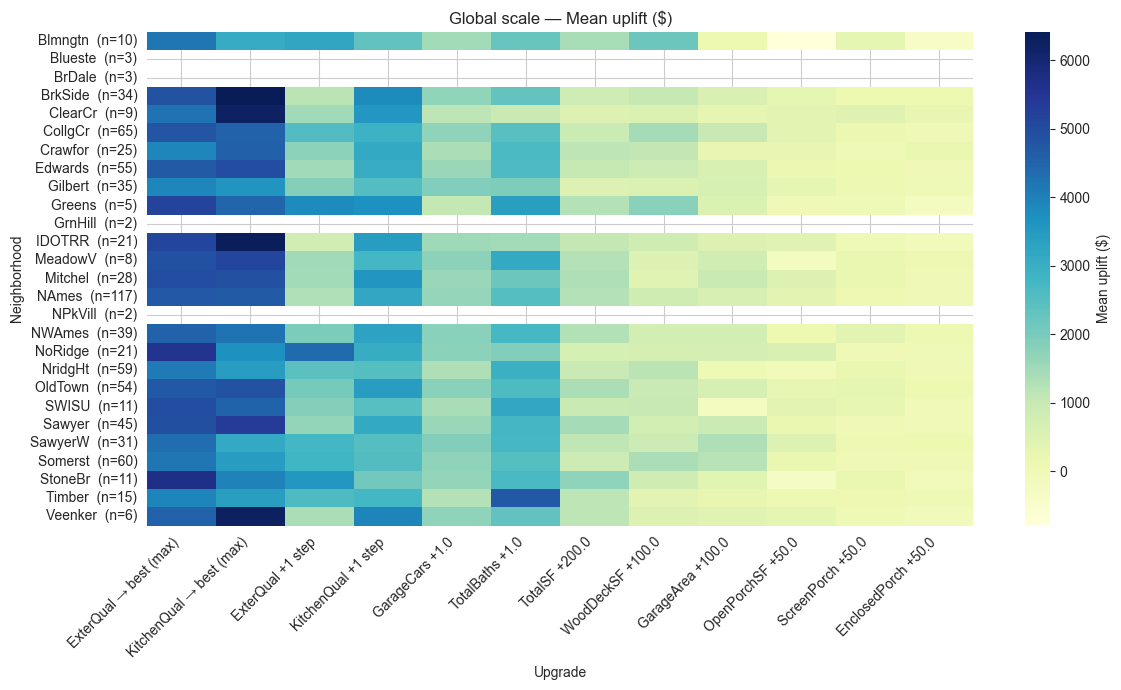

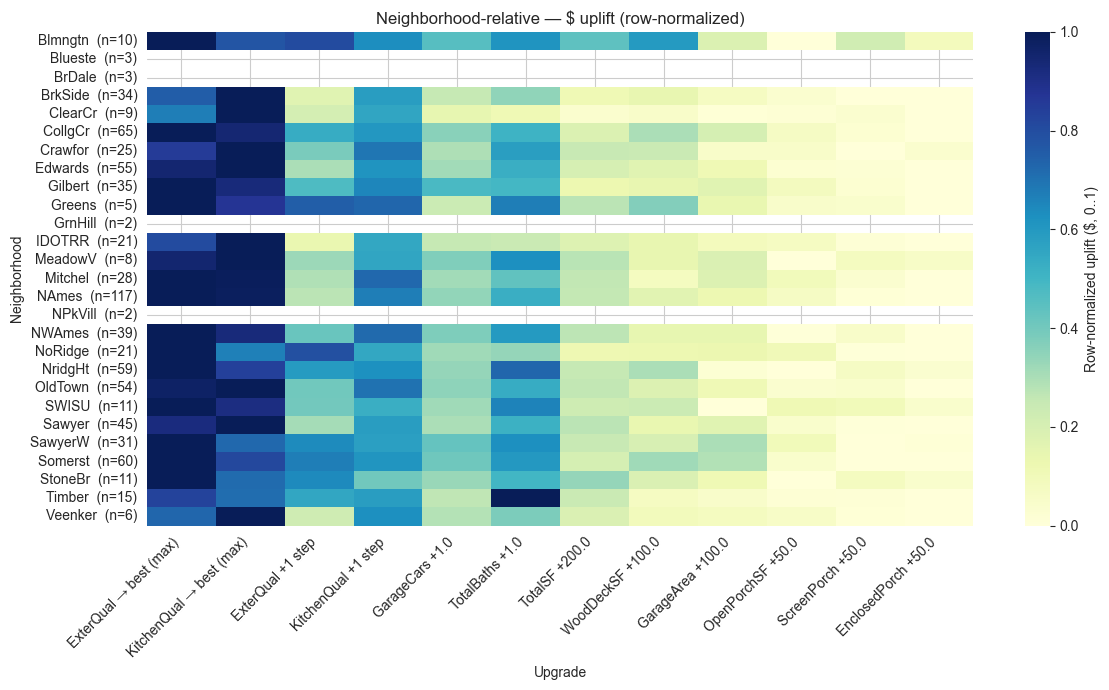

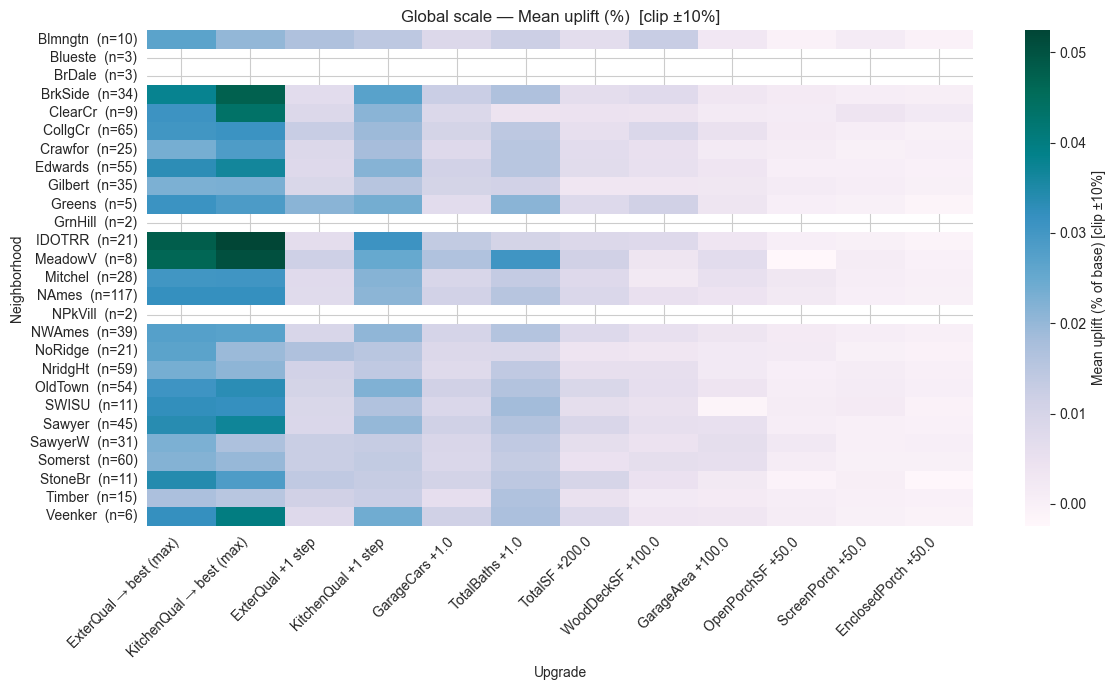

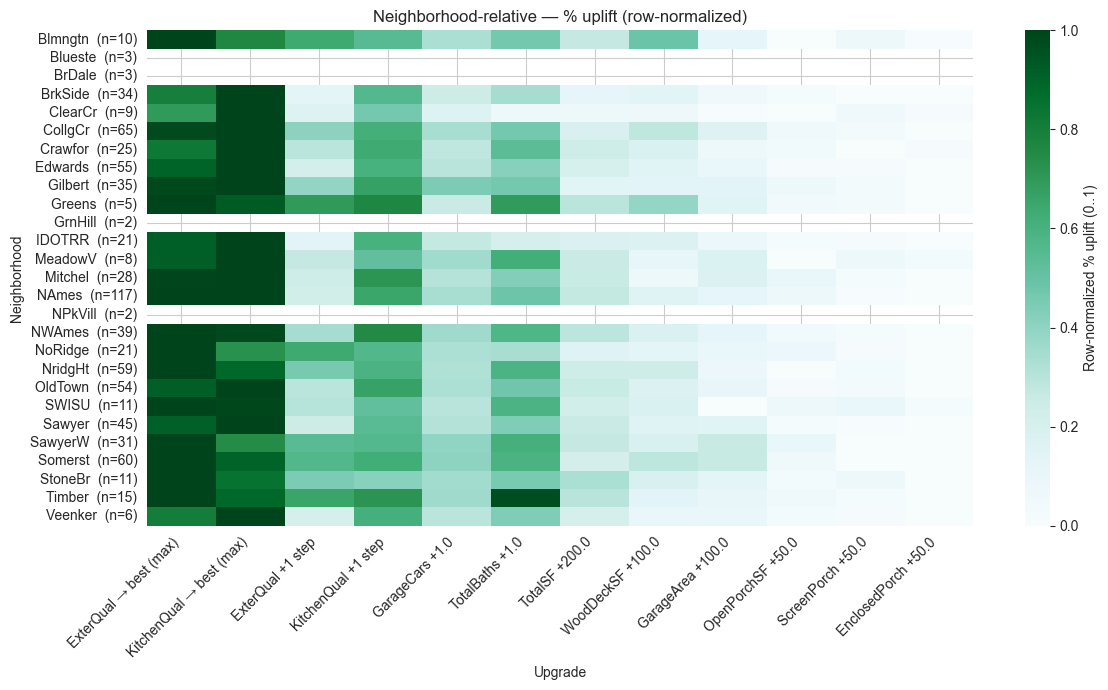

In [144]:
plot_uplift_heatmap_single(upgrades_long_ctx, UPGRADE_ORDER, kind="global_dollar")
plot_uplift_heatmap_single(upgrades_long_ctx, UPGRADE_ORDER, kind="rel_dollar")
plot_uplift_heatmap_single(upgrades_long_ctx, UPGRADE_ORDER, kind="global_percent")
plot_uplift_heatmap_single(upgrades_long_ctx, UPGRADE_ORDER, kind="rel_percent")

In [156]:
def global_upgrade_ranking(upgrades_long, min_n=5):
    """Return median/IQR uplift rankings per upgrade."""
    stats = (
        upgrades_long
        .groupby("upgrade")
        .agg({
            "uplift": ["count", "median", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
            "pct_uplift": ["median", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]
        })
    )

    # Flatten MultiIndex columns
    stats.columns = [
        "n", "median_$", "q25_$", "q75_$",
        "median_pct", "q25_pct", "q75_pct"
    ]
    stats = stats.reset_index()

    # Compute IQRs
    stats["iqr_$"] = stats["q75_$"] - stats["q25_$"]
    stats["iqr_pct"] = stats["q75_pct"] - stats["q25_pct"]

    # Filter and sort
    stats = stats.query("n >= @min_n")
    stats = stats.sort_values(["median_$", "iqr_$"], ascending=[False, True])
    return stats

def build_neighborhood_playbook(upgrades_long_ctx, 
                                 min_n=5, 
                                 top_k=3, 
                                 sort_by='mean_uplift_pct'):
    """
    Build a table of top-k upgrades per Neighborhood.
    sort_by: 'mean_uplift_pct' or 'mean_uplift_dollar'
    """
    df = upgrades_long_ctx.copy()

    # Calculate % uplift if not already present
    if "pct_uplift" not in df.columns:
        df["pct_uplift"] = df["uplift"] / df["base_pred"]
        df["pct_uplift"] = df["pct_uplift"].clip(-0.10, 0.10)

    # Aggregate: mean uplift and count
    agg = (
        df.groupby(["Neighborhood", "upgrade"], as_index=False)
          .agg(
              mean_uplift_dollar=("uplift", "mean"),
              mean_uplift_pct=("pct_uplift", "mean"),
              n=("uplift", "count")
          )
    )

    # Filter for enough samples
    agg = agg[agg["n"] >= min_n]

    # Sort within each Neighborhood
    agg_sorted = (
        agg.sort_values(by=["Neighborhood", sort_by], ascending=[True, False])
            .groupby("Neighborhood")
            .head(top_k)
    )

    # Reorder and format
    playbook = (
        agg_sorted[["Neighborhood", "upgrade", "mean_uplift_dollar", "mean_uplift_pct", "n"]]
            .sort_values(["Neighborhood", sort_by], ascending=[True, False])
            .reset_index(drop=True)
    )

    return playbook

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_global_upgrade_ranking(upgrade_stats, top_n=10):
    # Set plot style
    sns.set_style("whitegrid")

    # Sort and select top N
    top = upgrade_stats.sort_values("median_$", ascending=False).head(top_n)

    # Plot 1: Raw $
    plt.figure(figsize=(10, 6))
    plt.barh(top["upgrade"], top["median_$"], xerr=top["iqr_$"], color="skyblue")
    plt.xlabel("Median uplift ($)")
    plt.title("Top Upgrades by Median Value Increase ($)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Plot 2: % uplift
    top_pct = upgrade_stats.sort_values("median_pct", ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_pct["upgrade"], 100 * top_pct["median_pct"], xerr=100 * top_pct["iqr_pct"], color="mediumseagreen")
    plt.xlabel("Median uplift (% of base price)")
    plt.title("Top Upgrades by Median % Value Increase")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

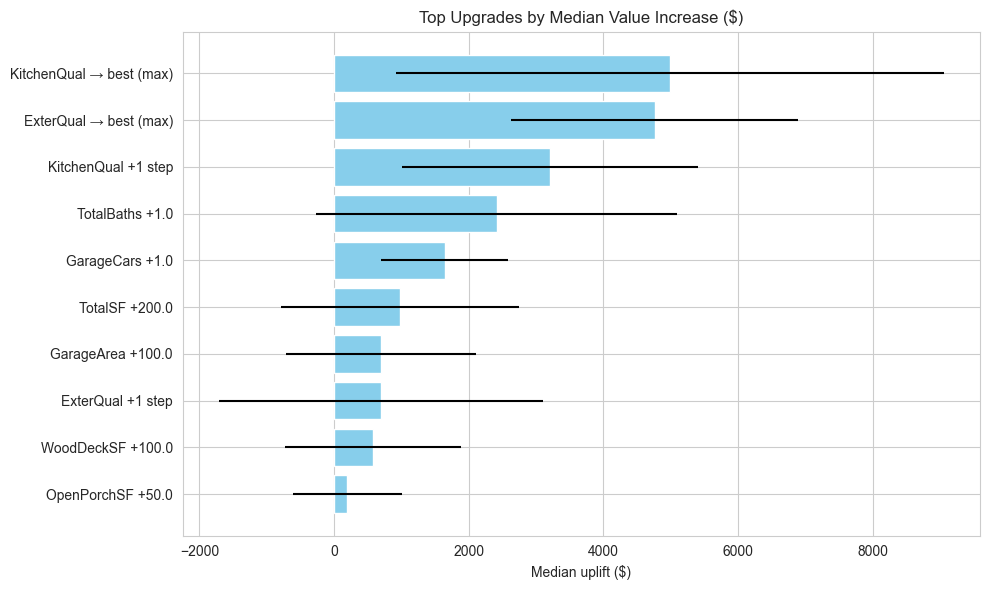

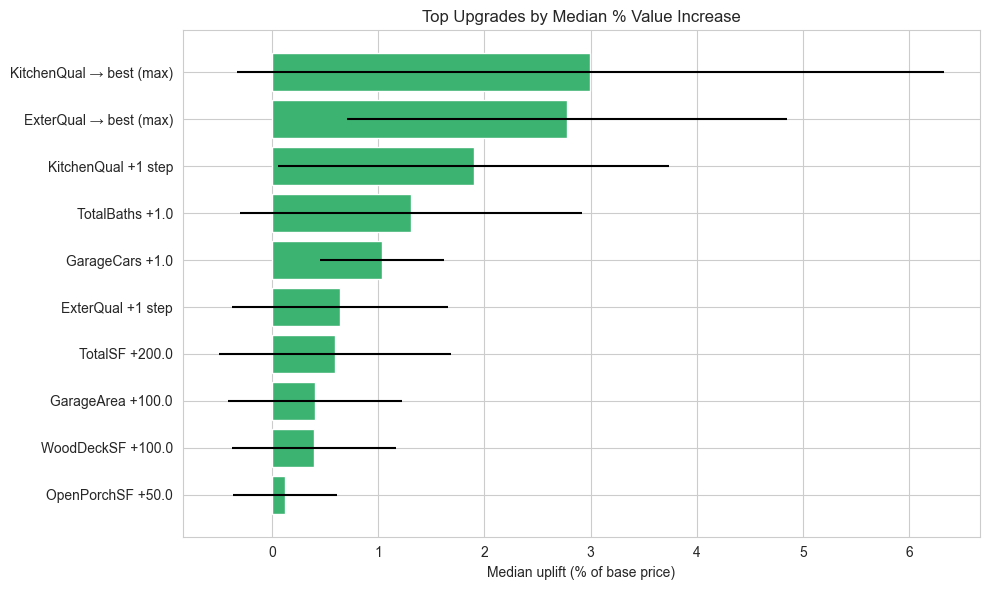

In [152]:
upgrades_long_ctx["pct_uplift"] = upgrades_long_ctx["uplift"] / upgrades_long_ctx["base_pred"]
upgrade_stats = global_upgrade_ranking(upgrades_long_ctx, min_n=5)
plot_global_upgrade_ranking(upgrade_stats)

In [157]:
playbook = build_neighborhood_playbook(upgrades_long_ctx, min_n=5, top_k=3, sort_by='mean_uplift_pct')
display(playbook)

,Neighborhood,upgrade,mean_uplift_dollar,mean_uplift_pct,n
0,Blmngtn,ExterQual → best (max),4189.575377,0.026569,10
1,Blmngtn,KitchenQual → best (max),3067.100677,0.022025,10
2,Blmngtn,ExterQual +1 step,3221.892627,0.016833,10
3,BrkSide,KitchenQual → best (max),6416.490123,0.052403,34
4,BrkSide,ExterQual → best (max),4860.926941,0.038945,34
...,...,...,...,...,...
64,Timber,TotalBaths +1.0,4732.164578,0.016652,15
65,Timber,KitchenQual → best (max),3381.653540,0.015159,15
66,Veenker,KitchenQual → best (max),6266.338614,0.039868,6
67,Veenker,ExterQual → best (max),4539.728384,0.032078,6


In [158]:
def display_pretty_playbook(playbook_df):
    df = playbook_df.copy()
    df["mean_uplift_dollar"] = df["mean_uplift_dollar"].map("${:,.0f}".format)
    df["mean_uplift_pct"] = df["mean_uplift_pct"].map("{:.1%}".format)
    display(df.rename(columns={
        "Neighborhood": "Neighborhood",
        "upgrade": "Upgrade",
        "mean_uplift_dollar": "Avg $ Uplift",
        "mean_uplift_pct": "Avg % Uplift",
        "n": "Samples"
    }))

In [165]:
display_pretty_playbook(playbook)

,Neighborhood,Upgrade,Avg $ Uplift,Avg % Uplift,Samples
0,Blmngtn,ExterQual → best (max),"$4,190",2.7%,10
1,Blmngtn,KitchenQual → best (max),"$3,067",2.2%,10
2,Blmngtn,ExterQual +1 step,"$3,222",1.7%,10
3,BrkSide,KitchenQual → best (max),"$6,416",5.2%,34
4,BrkSide,ExterQual → best (max),"$4,861",3.9%,34
...,...,...,...,...,...
64,Timber,TotalBaths +1.0,"$4,732",1.7%,15
65,Timber,KitchenQual → best (max),"$3,382",1.5%,15
66,Veenker,KitchenQual → best (max),"$6,266",4.0%,6
67,Veenker,ExterQual → best (max),"$4,540",3.2%,6


In [167]:
candidates_summary.head(20)

,_id_,_idx,y_true,residual,base_pred,best_uplift,best_new_pred,best_feature,best_upgrade,Neighborhood,MSZoning,KitchenQual,OverallQual,GrLivArea,TotalBaths,GarageArea,TotalSF,YearBuilt,YearRemodAdd
0,113,113,555000,9738.512811,545261.487189,16857.926482,562119.413671,TotalBaths,TotalBaths +1.0,NWAmes,RL,TA,7,2044,2.5,489.0,2782.0,1980,1988
1,113,113,555000,9738.512811,545261.487189,16857.926482,562119.413671,TotalBaths,TotalBaths +1.0,NridgHt,RL,Ex,10,2402,3.2,672.0,5496.0,2008,2008
2,113,113,555000,9738.512811,545261.487189,16857.926482,562119.413671,TotalBaths,TotalBaths +1.0,CollgCr,RL,Gd,7,1232,3.2,632.0,2464.0,2007,2007
3,579,579,425000,7225.176589,417774.823411,14659.945621,432434.769032,TotalBaths,TotalBaths +1.0,Timber,RL,Ex,9,1978,3.2,920.0,3956.0,2007,2007
4,579,579,425000,7225.176589,417774.823411,14659.945621,432434.769032,TotalBaths,TotalBaths +1.0,IDOTRR,C (all),TA,4,1336,1.5,570.0,1973.0,1920,1950
5,579,579,425000,7225.176589,417774.823411,14659.945621,432434.769032,TotalBaths,TotalBaths +1.0,NAmes,RL,TA,7,1986,2.5,486.0,2754.0,1965,1990
6,620,620,256000,5261.315845,250738.684155,14296.729380,265035.413535,KitchenQual,KitchenQual → best (max),Sawyer,RL,TA,6,1921,2.0,576.0,3842.0,1964,1964
7,620,620,256000,5261.315845,250738.684155,14296.729380,265035.413535,KitchenQual,KitchenQual → best (max),NAmes,RL,TA,4,1040,2.0,420.0,1040.0,1949,1950
8,620,620,256000,5261.315845,250738.684155,14296.729380,265035.413535,KitchenQual,KitchenQual → best (max),OldTown,RM,TA,6,2792,2.0,520.0,4302.0,1920,1950
9,818,818,404000,9146.774208,394853.225792,14115.298191,408968.523983,TotalBaths,TotalBaths +1.0,NridgHt,RL,Ex,9,2020,3.2,896.0,4040.0,2008,2008


In [173]:
top_candidates_best = (
    upgrades_long_ctx
    .sort_values("uplift", ascending=False)
    .groupby("_id_")        # group by home ID
    .head(1)                # keep only the highest-uplift upgrade
    .reset_index(drop=True)
)

top_candidates_best.head(10)

,_id_,_idx,upgrade,feature,base_pred,new_pred,uplift,residual,y_true,Neighborhood,_pct_uplift,pct_uplift
0,113,113,TotalBaths +1.0,TotalBaths,545261.487189,562119.413671,16857.926482,9738.512811,555000.0,NWAmes,0.030917,0.030917
1,"532 532\n532 532\nName: _id_, dtype: object",532,KitchenQual → best (max),KitchenQual,155528.898349,170822.473278,15293.574929,4471.101651,160000.0,OldTown,0.098333,0.098333
2,579,579,TotalBaths +1.0,TotalBaths,417774.823411,432434.769032,14659.945621,7225.176589,425000.0,Timber,0.035091,0.035091
3,620,620,KitchenQual → best (max),KitchenQual,250738.684155,265035.413535,14296.729380,5261.315845,256000.0,Sawyer,0.057018,0.057018
4,818,818,TotalBaths +1.0,TotalBaths,394853.225792,408968.523983,14115.298191,9146.774208,404000.0,NridgHt,0.035748,0.035748
5,"605 605\n605 605\nName: _id_, dtype: object",605,TotalBaths +1.0,TotalBaths,314970.723976,328987.515239,14016.791263,5029.276024,320000.0,Edwards,0.044502,0.044502
6,"683 683\n683 683\nName: _id_, dtype: object",683,TotalBaths +1.0,TotalBaths,370978.160824,384454.976963,13476.816139,7021.839176,378000.0,NridgHt,0.036328,0.036328
7,333,333,TotalBaths +1.0,TotalBaths,374255.645255,387051.128571,12795.483316,4244.354745,378500.0,Timber,0.034189,0.034189
8,207 207\n207 207\n207 207\nName: _id_...,207,KitchenQual → best (max),KitchenQual,232509.399858,245243.807431,12734.407573,8990.600142,241500.0,NWAmes,0.054769,0.054769
9,228,228,KitchenQual → best (max),KitchenQual,60353.114266,72640.039186,12286.924920,3646.885734,64000.0,BrkSide,0.203584,0.203584


In [175]:
# --- 0) Build X_features from X_adj/X_fe (if you haven't already)
X_features = X_adj.copy()            # or X_fe, whichever you want
X_features = X_features.reset_index().rename(columns={"index": "_id_"})

# --- 1) Coerce _id_ to a clean integer on BOTH dataframes

# Left side: handle cases where _id_ looks like "1    1\n1    1" etc.
# Extract the last group of digits; if none, set NA
top_candidates_best["_id_"] = (
    top_candidates_best["_id_"]
        .astype(str)
        .str.extract(r'(\d+)$')[0]      # last run of digits
        .astype("Int64")                # nullable int
)

# Right side: ensure _id_ is integer too
X_features["_id_"] = pd.to_numeric(X_features["_id_"], errors="coerce").astype("Int64")

# Optional: sanity check
missing_left  = top_candidates_best["_id_"].isna().sum()
missing_right = X_features["_id_"].isna().sum()
if missing_left or missing_right:
    print(f"[warn] NA ids after coercion — left:{missing_left}, right:{missing_right}")

# --- 2) Merge on a consistent int key
top_candidates_best = top_candidates_best.merge(
    X_features, on="_id_", how="left"
)

# Optional: verify merge coverage
unmatched = top_candidates_best["_id_"].isna().sum() + top_candidates_best.isna().all(axis=1).sum()
print("Post-merge shape:", top_candidates_best.shape)

[warn] NA ids after coercion — left:166, right:0
Post-merge shape: (1279, 100)


In [176]:
# 1) Collapse upgrades → keep only best upgrade per home
top_candidates_best = (
    upgrades_long_ctx
    .sort_values("uplift", ascending=False)
    .groupby("_id_")
    .head(1)
    .reset_index(drop=True)
)

# 2) Merge with the full feature set (X_fe or X_adj)
#    ⚠️ Make sure the index of X_fe/X_adj aligns with your "_id_"
X_features = X_adj.copy()  # or X_fe, depending on which schema you want
X_features = X_features.reset_index().rename(columns={"index": "_id_"})

top_candidates_best = top_candidates_best.merge(
    X_features,
    on="_id_",
    how="left"
)

# 3) Quick check
print(top_candidates_best.head())
print("Shape after merge:", top_candidates_best.shape)

ValueError: You are trying to merge on object and int64 columns for key '_id_'. If you wish to proceed you should use pd.concat